In [5]:
import os
import sys
import importlib

import pandas as pd
import uproot as up
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from pathlib import Path
import os.path
import csv
import pyroot as pr

from matplotlib import pyplot as plt
from math import cos, cosh, radians
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator

import awkward as ak

# DataFrame Construction

In [6]:
parsed_events = []
print("reading dataset")
#for file in os.listdir(r"./PrivateSignal16_test/MH1000_Ma100_MChi45"):
for file in os.listdir(r"D:\taisd\Documentos\UERJ\IC\Higgs-to-tautau\dataset\dataset"):
    print(file)
    try:
        #dataset = up.open(os.path.join(r"./PrivateSignal16_test/MH1000_Ma100_MChi45", file))
        dataset = up.open(os.path.join(r"D:\taisd\Documentos\UERJ\IC\Higgs-to-tautau\dataset\dataset", file))
        tree = dataset.get("Events;1")
        #abaixo com menos branches 
        objects = ["genWeight","nTau", "Tau_pt", "Tau_dxy", "Tau_dz", "Tau_eta", "Tau_phi", "Tau_mass","Tau_charge", "Tau_decayMode","Tau_idDecayMode","Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSmu","nJet", "Jet_area", "Jet_pt", "Jet_eta", "Jet_puId", "Jet_jetId"]
        #abaixo com mais branches
        #objects = ["genWeight","nTau", "Tau_pt", "Tau_dxy", "Tau_dz", "Tau_eta", "Tau_phi","Tau_leadTkDeltaEta", "Tau_leadTkDeltaPhi", "Tau_leadTkPtOverTauPt", "Tau_mass", "Tau_neutralIso",  "Tau_photonsOutsideSignalCone", "Tau_chargedIso", "Tau_puCorr", "Tau_rawAntiEle", "Tau_rawAntiEle2018", "Tau_rawDeepTau2017v2p1VSe", "Tau_rawDeepTau2017v2p1VSjet", "Tau_rawDeepTau2017v2p1VSmu", "Tau_rawIso", "Tau_rawIsodR03", "Tau_rawMVAnewDM2017v2", "Tau_rawMVAoldDM", "Tau_rawMVAoldDM2017v1", "Tau_rawMVAoldDM2017v2", "Tau_rawMVAoldDMdR032017v2", "Tau_charge", "Tau_decayMode", "Tau_jetIdx", "Tau_rawAntiEleCat", "Tau_rawAntiEleCat2018", "Tau_cleanmask", "Tau_genPartIdx", "Tau_genPartFlav", "Tau_idDecayMode", "Tau_idAntiEleDeadECal", "Tau_idAntiEle", "Tau_idAntiEle2018", "Tau_idAntiMu", "Tau_idDecayModeNewDMs", "Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSmu", "Tau_idMVAnewDM2017v2", "Tau_idMVAoldDM", "Tau_idMVAoldDM2017v1", "Tau_idMVAoldDM2017v2", "Tau_idMVAoldDMdR032017v2", "nJet", "Jet_area", "Jet_btagCSVV2", "Jet_btagDeepB", "Jet_btagDeepCvB", "Jet_btagDeepCvL", "Jet_btagDeepFlavB", "Jet_btagDeepFlavCvB", "Jet_btagDeepFlavCvL", "Jet_btagDeepFlavQG", "Jet_pt", "Jet_eta", "Jet_puId", "Jet_jetId"]
        events = tree.arrays(objects)

        for event in events:
            event = {k: getattr(event, k) for k in objects}
            parsed_events.append(event)

    except:
        print("fail")
        break
print("done")

datasets = parsed_events

reading dataset
1F343B3A-A003-9D42-956A-63D0E972E3E9.root
2FCFCFB1-696A-E84E-98B3-5FE5D2445345.root
42DAD507-A3E8-DC4D-96F4-D85B9607935C.root
55DF9C9F-05E5-8842-BF5E-CE86BCFC8882.root
8729905A-86FF-814A-B31C-6713A78BB76A.root
8CD9F2FC-76B7-E844-82EF-6B509F8C1A04.root
EBB395DE-4617-B843-95CA-FEFB86253D89.root
F38DB76E-F009-A84F-A958-368C6E212E9A.root
done


In [7]:
df = pd.DataFrame(datasets)
print(len(df))

246000


In [9]:
df['genWeight'].sum()


11044.014

# Object Selection (taus)

In [10]:
# Function to remove items below the threshold from a list and their corresponding items at the same index
def remove_below_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item < threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row

In [11]:
# Function to remove items above the threshold from a list and their corresponding items at the same index
def remove_above_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) > threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row

In [12]:
# Function to remove items not equal to the threshold from a list and their corresponding items at the same index
def remove_non_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item != threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row


In [13]:
# Threshold for filtering
#threshold = 0 #0,1,3,7,15
# Column name for which to remove items below the threshold
#column_name = 'Tau_idDeepTau2017v2p1VSmu'
# Apply the function to each row

#assim fica dentro do esperado MI prox 90
#df = df.apply(remove_non_threshold, args=(column_name, threshold), axis=1)
#assim diverge mto, mas é oq ta na referencia
#df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [14]:
# Threshold for filtering
#threshold = 1 #0, 1, 3, 7, 15, 31, 63, 127, 255
# Column name for which to remove items below the threshold
#column_name = 'Tau_idDeepTau2017v2p1VSjet'
# Apply the function to each row
#df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [15]:
# Threshold for filtering
#threshold = 0 #0, 1, 3, 7, 15, 31, 63, 127, 255
# Column name for which to remove items below the threshold
#column_name = 'Tau_idDeepTau2017v2p1VSe'
# Apply the function to each row
#df = df.apply(remove_non_threshold, args=(column_name, threshold), axis=1)

In [16]:
# Threshold for filtering
threshold = 20.0
# Column name for which to remove items below the threshold
column_name = 'Tau_pt'
# Apply the function to each row
df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [17]:
# Threshold for filtering
threshold = 2.4
# Column name for which to remove items below the threshold
column_name = 'Tau_eta'
# Apply the function to each row
df = df.apply(remove_above_threshold, args=(column_name, threshold), axis=1)

In [18]:
# Threshold for filtering
threshold = 0.2
# Column name for which to remove items below the threshold
column_name = 'Tau_dz'
# Apply the function to each row
df = df.apply(remove_above_threshold, args=(column_name, threshold), axis=1)

# Event Selection (taus)

In [19]:
# df = df[df['nTau'] != 2] # Delete events with 2 taus
df = df[df['nTau'] == 2] # keep event with 2 taus
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,Tau_idDecayMode,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
2,0.044603,2,"[117.87956, 80.37158]","[5.8442354e-05, -0.0013685226]","[-0.0034058094, 0.033456802]","[1.8581543, 2.0141602]","[-3.0463867, -2.0092773]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[31, 255]","[255, 255]","[0, 0]",4,"[0.48876953, 0.4987793, 0.5288086, 0.38891602]","[137.625, 95.5625, 35.4375, 16.765625]","[1.8557129, 2.0151367, 2.7270508, 4.9101562]","[4, 4, 7, 6]","[0, 2, 6, 0]"
3,0.044603,2,"[134.73776, 61.82594]","[-0.00017821789, -0.0014352798]","[0.0023950338, -0.006166935]","[-0.6015625, -0.2849121]","[1.2062988, 2.0234375]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",9,"[0.48876953, 0.5288086, 0.47875977, 0.50878906...","[143.375, 68.1875, 33.8125, 23.515625, 23.3281...","[-0.60424805, -0.26757812, 0.8170166, 3.485839...","[6, 4, 6, 0, 0, 0, 4, 6, 4]","[2, 2, 6, 6, 6, 6, 6, 6, 0]"
6,0.044603,2,"[109.81783, 38.773117]","[5.2064657e-05, -0.0009498596]","[0.0023766756, -0.0021935701]","[1.1455078, 0.3684082]","[1.9289551, 3.1015625]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",6,"[0.47875977, 0.5385742, 0.4987793, 0.55859375,...","[121.9375, 60.25, 41.34375, 38.34375, 24.85937...","[1.1455078, -0.58251953, 0.37329102, 1.8884277...","[4, 7, 4, 4, 0, 7]","[0, 6, 2, 6, 6, 6]"
7,0.044603,2,"[94.174614, 74.69332]","[-0.00016260147, -0.0020542145]","[-0.0034399033, -0.0025146008]","[0.09100342, -0.7515869]","[1.8757324, 1.3232422]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[15, 7]","[7, 3]",6,"[0.4987793, 0.50878906, 0.4987793, 0.44873047,...","[98.1875, 80.5, 62.90625, 26.59375, 17.59375, ...","[0.098464966, -0.7508545, -1.7456055, -1.07910...","[4, 4, 7, 7, 0, 4]","[2, 2, 6, 6, 6, 6]"
8,0.044603,2,"[68.391075, 41.55966]","[0.013183594, 0.0009126663]","[0.007885933, 0.0016394258]","[-0.15548706, -0.70654297]","[-1.2824707, -2.434082]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 31]","[255, 3]","[15, 15]",6,"[0.4987793, 0.48876953, 0.5288086, 0.33911133,...","[70.0, 54.90625, 17.390625, 16.34375, 16.28125...","[-0.15127563, -0.6939697, -1.1147461, -0.59057...","[4, 4, 6, 7, 0, 4]","[6, 6, 6, 6, 6, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245990,0.044641,2,"[33.88711, 20.385242]","[0.0011453629, 0.006175995]","[0.002132535, 0.010624886]","[0.017601013, -1.4885254]","[0.32946777, 0.39312744]","[0.13952637, 0.4404297]","[-1, 1]","[0, 1]","[True, True]","[7, 15]","[63, 1]","[15, 15]",8,"[0.5288086, 0.47875977, 0.46875, 0.50878906, 0...","[137.875, 70.1875, 39.71875, 18.28125, 15.8515...","[0.30358887, -1.4987793, 0.03453827, -1.640136...","[7, 4, 4, 4, 6, 0, 6, 4]","[6, 6, 6, 6, 6, 6, 6, 6]"
245994,0.044641,2,"[91.24304, 63.58553]","[0.0003578663, -0.00026798248]","[0.0010479689, 0.0020605326]","[-2.0756836, -0.9732666]","[-2.7836914, -2.84375]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[15, 127]","[7, 255]","[0, 0]",5,"[0.46875, 0.47875977, 0.40893555, 0.46875, 0.5...","[113.5, 69.1875, 19.03125, 16.671875, 15.1796875]","[-2.0649414, -0.977417, -2.071289, 4.3378906, ...","[4, 4, 6, 7, 6]","[2, 2, 6, 6, 6]"
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",5,"[0.50878906, 0.48876953, 0.5288086, 0.54833984...","[106.6875, 92.9375, 59.34375, 34.34375, 17.265...","[0.62231445, -0.1496582, 1.1801758, 2.244629, ...","[4, 4, 7, 6, 7]","[6, 2, 6, 6, 6]"
245997,0.044641,2,"[116.44638, 56.146713]","[-0.00036215782, -0.0013999939]","[0.00011245906, 0.011298656]

# Object Selection (jets)


In [20]:
# Function to remove items below the threshold from a list and their corresponding items at the same index
def remove_below_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item < threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [21]:
# Function to remove items above the threshold from a list and their corresponding items at the same index
def remove_above_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) > threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [22]:
# Function to remove items different threshold from a list and their corresponding items at the same index
def remove_dif_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) != threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [23]:
# Threshold for filtering
threshold = 20.0
# Column name for which to remove items below the threshold
column_name = 'Jet_pt'
# Apply the function to each row
df = df.apply(remove_below_threshold_1, args=(column_name, threshold), axis=1)

In [24]:
# Threshold for filtering
threshold = 2.4
# Column name for which to remove items below the threshold
column_name = 'Jet_eta'
# Apply the function to each row
df = df.apply(remove_above_threshold_1, args=(column_name, threshold), axis=1)

In [25]:
# Threshold for filtering
threshold = 0.4
# Column name for which to remove items below the threshold
column_name = 'Jet_area'
# Apply the function to each row
df = df.apply(remove_below_threshold_1, args=(column_name, threshold), axis=1)

In [26]:
# Threshold for filtering
threshold = 7
# Column name for which to remove items below the threshold
column_name = 'Jet_puId'
# Apply the function to each row
df = df.apply(remove_dif_threshold_1, args=(column_name, threshold), axis=1)

# Event Selection (jets)

In [27]:
# df = df[df['nJet'] <= 1] # Delete events with 1 or more jets
df = df[df['nJet'] >= 1] # keep event with 1 or more jets
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,Tau_idDecayMode,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
6,0.044603,2,"[109.81783, 38.773117]","[5.2064657e-05, -0.0009498596]","[0.0023766756, -0.0021935701]","[1.1455078, 0.3684082]","[1.9289551, 3.1015625]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",2,"[0.5385742, 0.50878906]","[60.25, 22.609375]","[-0.58251953, -0.9165039]","[7, 7]","[6, 6]"
7,0.044603,2,"[94.174614, 74.69332]","[-0.00016260147, -0.0020542145]","[-0.0034399033, -0.0025146008]","[0.09100342, -0.7515869]","[1.8757324, 1.3232422]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[15, 7]","[7, 3]",2,"[0.4987793, 0.44873047]","[62.90625, 26.59375]","[-1.7456055, -1.0791016]","[7, 7]","[6, 6]"
12,0.044603,2,"[132.05415, 28.244772]","[-0.00062179565, 0.007987976]","[0.02383709, -0.0026562214]","[1.0224609, -0.23574829]","[-0.32910156, -0.9725342]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[127, 3]","[3, 7]",1,[0.48876953],[26.28125],[0.18447876],[7],[6]
13,0.044603,2,"[131.85806, 62.7188]","[0.0009832382, -0.00079107285]","[0.00018493831, -0.0011999607]","[1.0332031, 0.10736084]","[1.2941895, 1.0068359]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]","[True, True]","[15, 255]","[255, 255]","[0, 0]",2,"[0.50878906, 0.4987793]","[170.875, 69.8125]","[-1.1538086, 0.34832764]","[7, 7]","[6, 6]"
14,0.044603,2,"[202.67912, 81.86428]","[-0.0065612793, -0.00019359589]","[0.010029316, 0.0018969774]","[-0.22213745, -0.6411133]","[-0.17199707, -0.72766113]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]","[True, True]","[0, 0]","[15, 31]","[7, 7]",3,"[0.54833984, 0.4987793, 0.5385742]","[206.125, 60.84375, 46.28125]","[0.3527832, 1.5932617, -0.47314453]","[7, 7, 7]","[6, 6, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245989,0.044641,2,"[79.09974, 74.12482]","[0.012451172, -0.005443573]","[0.013945103, -0.0033569336]","[1.9189453, 1.5268555]","[-0.37719727, 0.80322266]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[15, 15]","[7, 7]",2,"[0.46875, 0.5288086]","[30.375, 22.078125]","[1.2263184, -0.45129395]","[7, 7]","[6, 6]"
245990,0.044641,2,"[33.88711, 20.385242]","[0.0011453629, 0.006175995]","[0.002132535, 0.010624886]","[0.017601013, -1.4885254]","[0.32946777, 0.39312744]","[0.13952637, 0.4404297]","[-1, 1]","[0, 1]","[True, True]","[7, 15]","[63, 1]","[15, 15]",1,[0.5288086],[137.875],[0.30358887],[7],[6]
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",1,[0.5288086],[59.34375],[1.1801758],[7],[6]
245997,0.044641,2,"[116.44638, 56.146713]","[-0.00036215782, -0.0013999939]","[0.00011245906, 0.011298656]","[-0.46069336, -1.3952637]","[1.0549316, 0.45428467]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 31]","[255, 255]","[0, 0]",2,"[0.47875977, 0.47875977]","[145.75, 79.5]","[1.5932617, 0.3394165]","[7, 7]","[6, 6]"


# Massa Invariante 

84.75466906482528


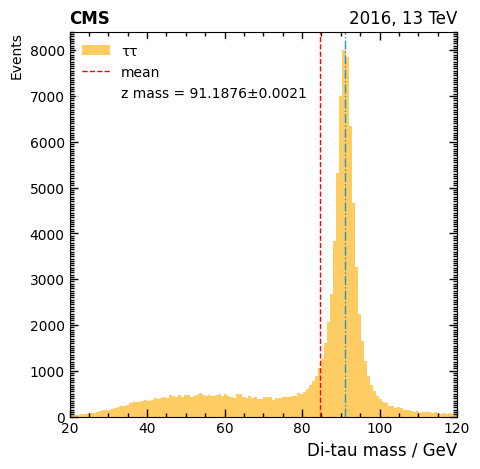

In [28]:
pts = []
etas = []
phis = []
massa = []

for i in range(len(df)):
    pts.append(df["Tau_pt"].iloc[i])
    etas.append(df["Tau_eta"].iloc[i])
    phis.append(df["Tau_phi"].iloc[i])
for i in range(len(pts)):
    try:
        massa.append((2 * pts[i][0] * pts[i][1] * (cosh(etas[i][0] - etas[i][1]) - cos(phis[i][0] - phis[i][1]))) ** (1/2))
    except:
        pass

z_mass = 91.1876#±0.0021

mean = np.mean(massa)
print(mean)
rms = np.sqrt(mean)

plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(massa, bins=1500, color="#ffcc64") #bins é 1500
plt.xlim(20, 120)
plt.xlabel("Di-tau mass / GeV", loc="right", fontsize='large')
plt.ylabel("Events", loc="top")
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch], edgecolor='white', title_fontsize='xx-small')
nova_legenda = plt.legend([patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                           plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1),
                           plt.axvline(z_mass, color='#2596be', linestyle='dashdot', linewidth=1)],
                            ['ττ','mean', 'z mass = 91.1876±0.0021'], edgecolor='white', title_fontsize= 'xx-small')
plt.title("CMS", loc="left", fontweight='bold')
plt.title("2016, 13 TeV", loc="right")

plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True,
                direction='in', length=6, width=1, colors='black')
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black', top=True, right=True)
ax = plt.gca()
ax.set_adjustable('datalim')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.show()


In [29]:
print(len(df))

99350


90.65707424635286


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


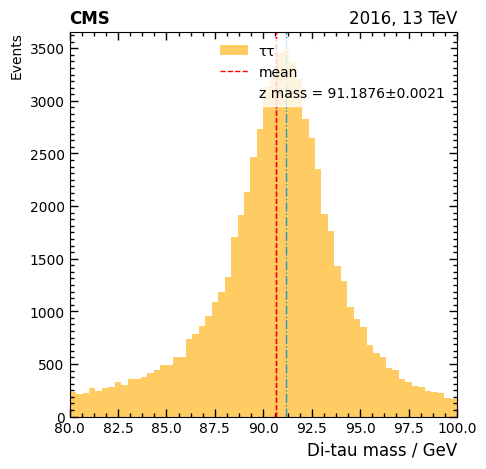

In [30]:
pts = []
etas = []
phis = []
massa2 = []

for i in range(len(df)):
    pts.append(df["Tau_pt"].iloc[i])
    etas.append(df["Tau_eta"].iloc[i])
    phis.append(df["Tau_phi"].iloc[i])
for i in range(len(pts)):
    try:
        massa2.append((2 * pts[i][0] * pts[i][1] * (cosh(etas[i][0] - etas[i][1]) - cos(phis[i][0] - phis[i][1]))) ** (1/2))
    except:
        pass

massa_corte = []
z_mass = 91.1876#±0.0021

for i in massa2:
  if i > 80.:
    if i < 100.:
      massa_corte.append(i)

mean = np.mean(massa_corte)
print(mean)
rms = np.sqrt(mean)


plt.figure(figsize=(5,5))
n, bins, patches = plt.hist(massa_corte, bins = 60, color = "#ffcc64")
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1)
#patches[48].set_fc('#2596be')
plt.xlim(80,100)
#plt.ylim(0,1900)
plt.xlabel("Di-tau mass / GeV", loc="right", fontsize='large')
plt.ylabel("Events", loc="top")
#blue_patch = mpatches.Patch(color='#2596be', label='Z→ττ')
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch], edgecolor='white', title_fontsize= 'xx-small')
legenda_existente = plt.legend()
nova_legenda = plt.legend([patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                           plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1),
                           plt.axvline(z_mass, color='#2596be', linestyle='dashdot', linewidth=1)],
                            ['ττ','mean', 'z mass = 91.1876±0.0021'], edgecolor='white', title_fontsize= 'xx-small')
plt.title("CMS", loc="left", fontweight='bold')
plt.title("2016, 13 TeV", loc="right")

plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True,
                direction='in', length=6, width=1, colors='black')
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black', top=True, right=True)
ax = plt.gca()
ax.set_adjustable('datalim')
ax.xaxis.set_minor_locator(MultipleLocator(0.625))
ax.yaxis.set_minor_locator(MultipleLocator(62.50))

plt.show()

C:\Users\taisd\AppData\Local\Temp\ipykernel_16380\3535353700.py:36: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x0000023A5D7BFC10> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
C:\Users\taisd\AppData\Local\Temp\ipykernel_16380\3535353700.py:36: UserWarning: The label '_child61' of <matplotlib.lines.Line2D object at 0x0000023A4D68B100> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),


<Figure size 640x480 with 0 Axes>

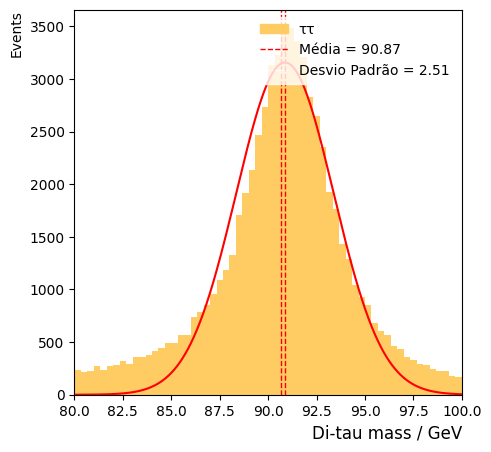

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches

# Função de ajuste gaussiano
def gaussiana(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Valores iniciais estimados para os parâmetros do ajuste
parametros_iniciais = [1000, np.mean(massa_corte), np.std(massa_corte)]

# Realize o ajuste usando curve_fit
parametros_otimizados, matriz_covariancia = curve_fit(gaussiana, bins[:-1], n, p0=parametros_iniciais)

# Extraia os parâmetros ajustados
A, mu, sigma = parametros_otimizados

# Crie um conjunto de pontos para plotar a curva ajustada
x_fit = np.linspace(min(bins), max(bins), 1000)
y_fit = gaussiana(x_fit, A, mu, sigma)

# Limpeza do gráfico para evitar que dois gráficos se sobreponham
plt.clf()

# histograma
plt.figure(figsize=(5, 5))
plt.hist(massa_corte, bins=60, color="#ffcc64")
plt.xlim(80, 100)
plt.xlabel("Di-tau mass / GeV", loc="right", fontsize='large')
plt.ylabel("Events", loc="top")

# Fit
plt.plot(x_fit, y_fit, 'r-', label=f'Ajuste Gaussiano\nMédia = {mu:.2f}, Desvio Padrão = {sigma:.2f}')
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                    plt.axvline(mu, color='r', linestyle='dashed', linewidth=1, label=f'Média = {mu:.2f}'),
                    plt.axvline(sigma, color='white', linestyle='dashdot', linewidth=1, label=f'Desvio Padrão = {sigma:.2f}')],
           edgecolor='white', title_fontsize='xx-small', loc='upper right')

plt.show()
desv_pad = sigma

# Encontrando as estatísticas 

In [33]:
mass = massa #massa invariante do sistema de dois taus
z_mass = 91.1876 #±0.0021    Helena pediu pra usar na verdade 90.7 +- 3.0 no olho msm
z_max = 93.7
z_min = 87.7
events = []
indices = []

for i in mass:
  if i > z_min and i < z_max:
    events.append(i)

for indice, valor in enumerate(mass):
    if valor in events:
        indices.append(indice)

#print("Índices dos eventos:", indices)
#print('eventos:', events)
print('quantidade de eventos na janela do z:', len(events))
print('quantidade total de eventos pós cortes:', len(mass))

ztau = 3.3662#±0.0066 %
ztau_max = ztau+0.0066
ztau_min = ztau-0.0066

peso_em_z = df.loc[df.index.isin(indices), 'genWeight'].sum()
peso_total = 11044.014  #SEMPRE substituir após rodar analysis_official com mais ou menos arquivos

print('quantidade total de eventos dentro da massa do Z (peso dos eventos):', peso_em_z)
print('quantidade total de eventos sem qualquer corte (peso dos eventos):', peso_total)

estatistica = peso_em_z/peso_total

erro_eventos_na_janela = np.sqrt(peso_em_z)
erro_eventos_gerados = np.sqrt(peso_total) 

erro_estatistico = np.sqrt(pow(erro_eventos_na_janela/peso_em_z, 2) + pow(erro_eventos_gerados/peso_total, 2))

print('porcentagem de ramificação do Z em dois taus na referência: (3.3662 ± 0.0066) %')
print('A estatística final é (',round(estatistica,10),'±', round(erro_estatistico,4),')%. ')
print('A discrepância é igual a:',abs(estatistica - 3.3662), ', onde 2sigma é igual a:', 2*erro_estatistico, 'ou seja, não é compatível.')

quantidade de eventos na janela do z: 44979
quantidade total de eventos pós cortes: 99350
quantidade total de eventos dentro da massa do Z (peso dos eventos): 806.3548630401492
quantidade total de eventos sem qualquer corte (peso dos eventos): 11044.014
porcentagem de ramificação do Z em dois taus na referência: (3.3662 ± 0.0066) %
A estatística final é ( 0.0730128433 ± 0.0365 )%. 
A discrepância é igual a: 3.293187156749335 , onde 2sigma é igual a: 0.07295740041838934 ou seja, não é compatível.


# Salvando os dados (opcional)


In [ ]:
##output_file = 'analysis_something.root'

# Converta o DataFrame em um dicionário de arrays numpy
##data_dict = {col: df[col].values for col in df.columns}

# Create a dictionary of column data types
##dtype_dict = {col: df[col].dtype for col in df.columns}

# Convert the DataFrame to a dictionary with NumPy arrays
##data_dict = {col: df[col].values for col in df.columns}

In [ ]:
# Pegue os nomes das colunas em uma lista
##col_names = df.columns.tolist()

# Pegue os valores das colunas em uma lista de listas
##col_values = df.values.tolist()

#awkward_arrays = [ak.Array(values) for values in col_values] 

In [ ]:
##output_filename = "analysis_official_wrong_cut.root"
##tree_name = "Events"

# Crie um dicionário de ramos onde a chave é o nome do ramo e o valor é o array correspondente
##branches = {}

# Itere pelas colunas do DataFrame
##for column_name in df.columns:
    # Se a coluna for a primeira ou a quadragesima nona branch, considere os inteiros
    ##if column_name == 'nTau' or column_name == 'nJet':
        ##numpy_array = np.array(df[column_name])
    ##else:
        # Crie um DataFrame intermediário para a coluna de objeto Awkward Array
        ##intermediate_df = pd.DataFrame(df[column_name])
        
        # Converta o DataFrame intermediário em NumPy array
        ##numpy_array = np.array(intermediate_df.iloc[:, 0])  # Use apenas a primeira coluna
        
    # Adicione o NumPy array ao dicionário de ramos
    ##branches[column_name] = numpy_array

# Crie o arquivo ROOT e insira os ramos
##with up.recreate(output_filename) as output_file:
    ##output_file[tree_name] = branches